## YeLP Reviews Sentiment Analysis and Topic Modeling

In [1]:
DF_PATH = '../data/processed/yelp_data_engineered.pkl'

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score, hamming_loss
import plotly.express as px

### Read dataset

In [3]:
df = pd.read_pickle(DF_PATH)
df.shape

(10000, 1004)

### Drop duplicated cool columns

In [4]:
duplicated_columns = df.columns[df.columns.duplicated(keep='first')]
column_to_drop = duplicated_columns[0] 

index_to_drop = df.columns.get_loc(column_to_drop)

df.drop(df.columns[index_to_drop], axis=1, inplace=True)

In [5]:
X = df.drop('stars', axis=1)
y = df['stars']

### Apply feature selection

In [6]:
k_best = SelectKBest(score_func=chi2, k=100) 
X_selected = k_best.fit_transform(X, y)

### Tune XGBoost Model

In [7]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [8]:
xgb_model = XGBClassifier()


In [9]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

scoring = {
    'F1 Micro': 'f1_micro',
    'Hamming Loss': make_scorer(hamming_loss, greater_is_better=False),
    'Accuracy': make_scorer(accuracy_score)
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=scoring,
    cv=kfold,
    refit='F1 Micro',
    verbose=1,
    n_jobs=-1
)

In [10]:
grid_search.fit(X_selected, y)

Fitting 2 folds for each of 243 candidates, totalling 486 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
         

In [11]:
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Micro Score: {:.2f}".format(grid_search.best_score_))
print("Best Hamming Loss: {:.4f}".format(grid_search.cv_results_['mean_test_Hamming Loss'][grid_search.best_index_]))
print("Best Accuracy: {:.2f}".format(grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_]))

Best Parameters:  {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
Best F1 Micro Score: 0.76
Best Hamming Loss: -0.2440
Best Accuracy: 0.76


In [12]:
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [13]:
scores = cross_val_score(best_model, X_selected, y, cv=kfold, scoring='accuracy')
print("Accuracy: {:.2f}".format(scores.mean() * 100))

Accuracy: 75.60


In [14]:
y_pred = best_model.predict(X_selected)
print("Accuracy: {:.2f}".format(accuracy_score(y, y_pred) * 100))

Accuracy: 82.95


In [15]:
cm = confusion_matrix(y, y_pred)
cm

array([[1081,   80,  515],
       [ 119,  504,  838],
       [  91,   62, 6710]], dtype=int64)

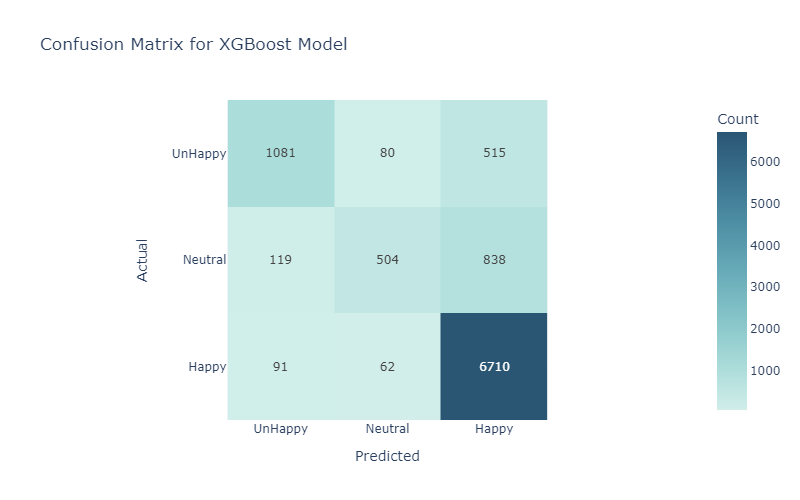

In [16]:
fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['UnHappy', 'Neutral', 'Happy'], y=['UnHappy', 'Neutral', 'Happy'],
                title="Confusion Matrix for XGBoost Model", 
                width=800, height=500,
                text_auto=True, color_continuous_scale='Teal')
fig.show(renderer="png")